# Load Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D ,MaxPooling2D, MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers. normalization import BatchNormalization
from keras.models import Sequential


from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

import numpy as np

import pandas as pd

image_path = "dataset_train/dataset/"
#!unzip dataset_train.zip
%matplotlib inline


# Load Data

In [2]:
def loadDataSet(path):
    def loadImages(path):
        # literalmente dar load das imagens todas para estes arrays
        # Listas por compreencao for life <3
        real = [image.load_img(image_path+"real/"+file,target_size = (28,28), color_mode='grayscale') for file in os.listdir(image_path+"real")]
        fake = [image.load_img(image_path+"fake/"+file,target_size = (28,28), color_mode='grayscale') for file in os.listdir(image_path+"/fake")]
        return real,fake

    def imagesToArray(imgs):
        return np.array([image.img_to_array(img)[:,:,0] for img in imgs])
    
    real,fake = loadImages(path)
    real_array = imagesToArray(real)
    fake_array = imagesToArray(fake)
    return real_array,fake_array
  
real,fake = loadDataSet(image_path)
len(real),len(fake)

(20000, 20000)

# Train Val Test

In [3]:
X = np.append(real,fake,axis=0)
y = np.append(np.ones((20000,1)),np.zeros((20000,1)))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=13)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=13)
print("Train -> {} [{}%] ".format(len(y_train),len(y_train)/40000*100))
print("Val   -> {} [{}%] ".format(len(y_val),len(y_val)/40000*100))
print("Test  -> {} [{}%] ".format(len(y_test),len(y_test)/40000*100))


Train -> 24000 [60.0%] 
Val   -> 8000 [20.0%] 
Test  -> 8000 [20.0%] 


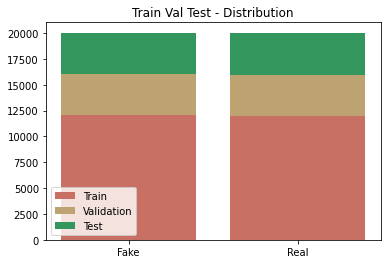

In [4]:
_, frequency_train = np.unique(y_train, return_counts = True)
_, frequency_val = np.unique(y_val, return_counts = True)
_, frequency_test = np.unique(y_test, return_counts = True)

plt.bar(["Fake","Real"], frequency_train,label ='Train',color="#C97064")
plt.bar(["Fake","Real"], frequency_val,label ='Validation',color="#BCA371",bottom=frequency_train)
plt.bar(["Fake","Real"], frequency_test,label ='Test',color="#32965D",bottom=np.add(frequency_train, frequency_test))
plt.legend()
plt.title("Train Val Test - Distribution")
plt.show()
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os
import h5py

In [6]:
# Feature Extraction

def fd_hu_moments(image):
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature
def fd_histogram(image):
    # compute the color histogram
    hist  = cv2.calcHist([image],  [0], None, [256], [0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()


def fill_features(x):
    x_features = []
    for img in x:
        
        hu_moment = fd_hu_moments(img)
        histogram = fd_histogram(img)
        x_features.append(np.hstack([hu_moment, histogram]))
    return x_features
X_train_features = fill_features(X_train)

## Models for the Ensemble

In [7]:
import warnings

from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

num_trees = 100
test_size = 0.10
seed      = 9
scoring    = "accuracy"
warnings.filterwarnings('ignore')


In [8]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

In [9]:
results = []
names   = []
scoring    = "accuracy"


In [10]:
for name, model in models:
    print(name, model)
    kfold = KFold(n_splits=10, random_state=seed,shuffle = True)
    cv_results = cross_val_score(model, X_train_features, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR LogisticRegression(random_state=9)
LR: 0.758875 (0.008813)
KNN KNeighborsClassifier()
KNN: 0.754458 (0.005221)
DT DecisionTreeClassifier(random_state=9)
DT: 0.960083 (0.002980)
RF RandomForestClassifier(random_state=9)
RF: 0.973083 (0.003324)
NB GaussianNB()
NB: 0.625167 (0.013387)
SVM SVC(random_state=9)
SVM: 0.732750 (0.010785)


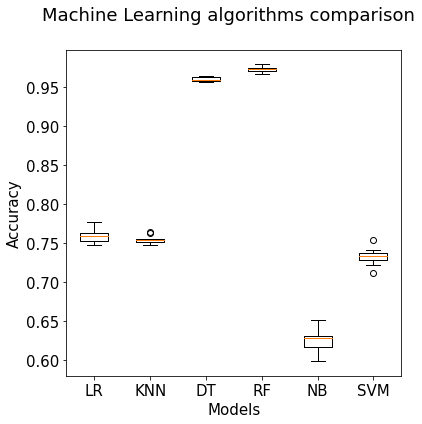

In [66]:
fig = pyplot.figure(figsize=(6,6))
fig.suptitle('Machine Learning algorithms comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Models")
pyplot.show()

In [12]:
for name, model in models:
    print("Training {}".format(name))
    model.fit(X_train_features,y_train)

Training LR
Training KNN
Training DT
Training RF
Training NB
Training SVM


In [67]:
X_val_features = fill_features(X_val)

In [68]:
predictions = []
for name, model in models:
    print("Validating {}".format(name))
    predictions.append(model.predict(X_val_features))

Validating LR
Validating KNN
Validating DT
Validating RF
Validating NB
Validating SVM


In [69]:
validations = pd.DataFrame(np.array(predictions).T,columns = names)
validations.to_csv("Models_Predictions_Validations.csv")
validations.head()

,LR,KNN,DT,RF,NB,SVM
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
validations["real"]=y_val
validations.head()

,LR,KNN,DT,RF,NB,SVM,real
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import f1_score 

In [72]:
w = np.array(results).mean(axis=1)
w_2 = np.array(results).mean(axis=1)**2
w_3 = np.array(results).mean(axis=1)**3
w_4 = np.array(results).mean(axis=1)**4
w_5 = np.array(results).mean(axis=1)**5


In [73]:
print(w)
print(w_2)
print(w_3)
print(w_4)
print(w_5)


[0.758875   0.75445833 0.96008333 0.97308333 0.62516667 0.73275   ]
[0.57589127 0.56920738 0.92176001 0.94689117 0.39083336 0.53692256]
[0.43702948 0.42944325 0.88496642 0.92140402 0.24433599 0.39343001]
[0.33165075 0.32399704 0.84964151 0.89660289 0.15275072 0.28828584]
[0.25168146 0.24444227 0.81572665 0.87246933 0.09549466 0.21124145]


In [74]:
emsemble_table = validations.drop(columns =["real"])

In [75]:
emsemble_table.iloc[2]

LR     0.0
KNN    0.0
DT     1.0
RF     1.0
NB     0.0
SVM    0.0
Name: 2, dtype: float64

In [76]:
def emsemble_algorithm(w):
    emsemble_predict = []
    for r in range(len(emsemble_table)):
        vote = {0:0,1:0}
        for i in range(len(w)):
            vote[emsemble_table.iloc[r][i]]+=w[i]

        emsemble_predict.append(max(vote, key=vote.get))
    emsemble_predict = np.array(emsemble_predict)
    return emsemble_predict

In [77]:
emsemble_predict_w = emsemble_algorithm(w)
emsemble_predict_w_2 = emsemble_algorithm(w_2)
emsemble_predict_w_3 = emsemble_algorithm(w_3)
emsemble_predict_w_4 = emsemble_algorithm(w_4)
emsemble_predict_w_5 = emsemble_algorithm(w_5)


In [78]:
def show_results(emsemble_predict):
    print("\tAccuracy")
    print(accuracy_score(emsemble_predict,validations["real"]))
    print("\tPrecision")
    print(precision_score(emsemble_predict,validations["real"]))
    print("\tRecall")
    print(recall_score(emsemble_predict,validations["real"]))
    print("\tAUC")
    print(roc_auc_score(emsemble_predict,validations["real"]))
    print("\tF1-Score")
    print(f1_score(emsemble_predict,validations["real"]))
    print()
    
show_results(emsemble_predict_w)
print()
show_results(emsemble_predict_w_2)
print()
show_results(emsemble_predict_w_3)
print()
show_results(emsemble_predict_w_4)
print()
show_results(emsemble_predict_w_5)
print()

	Accuracy
0.8895
	Precision
0.7913758723828515
	Recall
0.9854127870887648
	AUC
0.9051174441931893
	F1-Score
0.8777992811722422


	Accuracy
0.8895
	Precision
0.7913758723828515
	Recall
0.9854127870887648
	AUC
0.9051174441931893
	F1-Score
0.8777992811722422


	Accuracy
0.970625
	Precision
0.965852442671984
	Recall
0.9753335011326454
	AUC
0.9706565692899383
	F1-Score
0.9705698184095178


	Accuracy
0.970625
	Precision
0.965852442671984
	Recall
0.9753335011326454
	AUC
0.9706565692899383
	F1-Score
0.9705698184095178


	Accuracy
0.970625
	Precision
0.965852442671984
	Recall
0.9753335011326454
	AUC
0.9706565692899383
	F1-Score
0.9705698184095178




In [79]:
names = ["LR","KNN","DT","RF","NB","SVM"]

In [80]:
models_metrics = []
for c in names:
    model_metrics = []
    model_metrics.append(accuracy_score(validations[c],validations["real"]))
    model_metrics.append(precision_score(validations[c],validations["real"]))
    model_metrics.append(recall_score(validations[c],validations["real"]))
    model_metrics.append(roc_auc_score(validations[c],validations["real"]))
    model_metrics.append(f1_score(validations[c],validations["real"]))
    models_metrics.append(model_metrics)
model_metrics = []
model_metrics.append(accuracy_score(emsemble_predict_w_3,validations["real"]))
model_metrics.append(precision_score(emsemble_predict_w_3,validations["real"]))
model_metrics.append(recall_score(emsemble_predict_w_3,validations["real"]))
model_metrics.append(roc_auc_score(emsemble_predict_w_3,validations["real"]))
model_metrics.append(f1_score(emsemble_predict_w_3,validations["real"]))
models_metrics.append(model_metrics)

In [81]:
models_metrics

[[0.763125,
  0.6186440677966102,
  0.8717948717948718,
  0.7874402265048491,
  0.7237206589881906],
 [0.756625,
  0.5899800598205384,
  0.8868490071187711,
  0.789138253324908,
  0.7085765603951505],
 [0.957875,
  0.9536390827517448,
  0.9620316821724918,
  0.957898764277894,
  0.9578169983727626],
 [0.97525,
  0.9887836490528414,
  0.9628640776699029,
  0.9756330697627865,
  0.9756517461878996],
 [0.624125,
  0.3616650049850449,
  0.764891934633632,
  0.672631122158697,
  0.49111524792689115],
 [0.742125,
  0.5102193419740778,
  0.9543123543123543,
  0.8093508825361941,
  0.6649342212116292],
 [0.970625,
  0.965852442671984,
  0.9753335011326454,
  0.9706565692899383,
  0.9705698184095178]]

<AxesSubplot:>

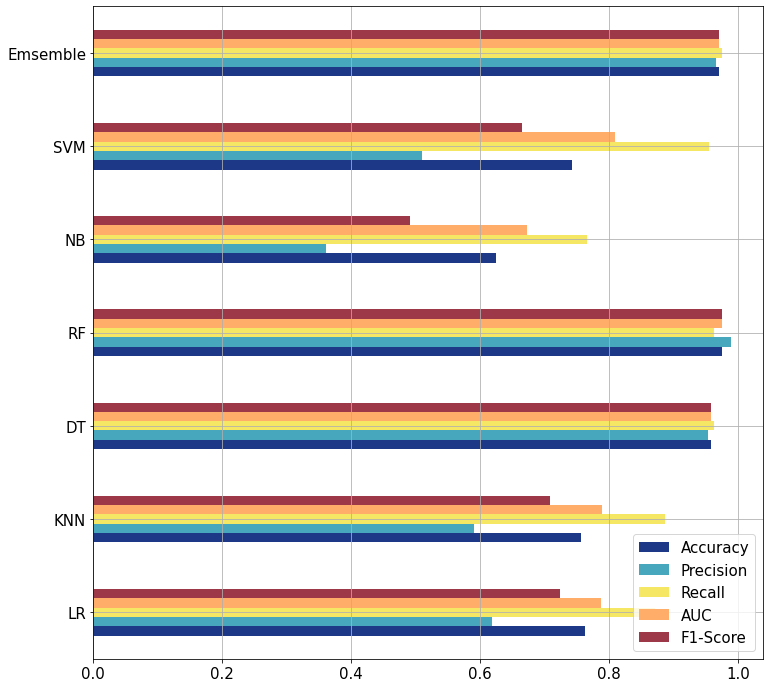

In [82]:

plt.rc('font', size=15) 
results_metrics = pd.DataFrame(np.array(models_metrics),
             index =["LR","KNN","DT","RF","NB","SVM","Emsemble"],
            columns = ["Accuracy","Precision","Recall","AUC","F1-Score"])
results_metrics.to_csv("results.csv")
results_metrics.plot.barh(color=["#1e3888","#47a8bd","#f5e663","#ffad69","#9c3848"],figsize=(12,12),grid=True )

In [83]:
results_metrics

,Accuracy,Precision,Recall,AUC,F1-Score
LR,0.763125,0.618644,0.871795,0.787440,0.723721
KNN,0.756625,0.589980,0.886849,0.789138,0.708577
DT,0.957875,0.953639,0.962032,0.957899,0.957817
RF,0.975250,0.988784,0.962864,0.975633,0.975652
NB,0.624125,0.361665,0.764892,0.672631,0.491115
SVM,0.742125,0.510219,0.954312,0.809351,0.664934
Emsemble,0.970625,0.965852,0.975334,0.970657,0.970570


In [85]:
X_test_features = fill_features(X_test)

In [86]:
predictions_test = []
for name, model in models:
    print("Testing {}".format(name))
    predictions_test.append(model.predict(X_test_features))

Testing LR
Testing KNN
Testing DT
Testing RF
Testing NB
Testing SVM


In [87]:
tests = pd.DataFrame(np.array(predictions_test).T,columns = names)

tests["real"]=y_test
tests.head()


,LR,KNN,DT,RF,NB,SVM,real
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [88]:
emsemble_table_test = tests.drop(columns =["real"])

In [89]:
emsemble_predict_test = []
for r in range(len(emsemble_table_test)):
    vote = {0:0,1:0}
    for i in range(len(w)):
        vote[emsemble_table_test.iloc[r][i]]+=w_3[i]

    emsemble_predict_test.append(max(vote, key=vote.get))
emsemble_predict_test = np.array(emsemble_predict_test)
emsemble_predict_test

array([0, 1, 0, ..., 1, 1, 1])

In [90]:
test_metrics=[]
test_metrics.append(accuracy_score(emsemble_predict_test,y_test))
test_metrics.append(precision_score(emsemble_predict_test,y_test))
test_metrics.append(recall_score(emsemble_predict_test,y_test))
test_metrics.append(roc_auc_score(emsemble_predict_test,y_test))
test_metrics.append(f1_score(emsemble_predict_test,y_test))


,Emsemble
Accuracy,0.970250
Precision,0.967383
Recall,0.973638
AUC,0.970232
F1-Score,0.970501


<AxesSubplot:>

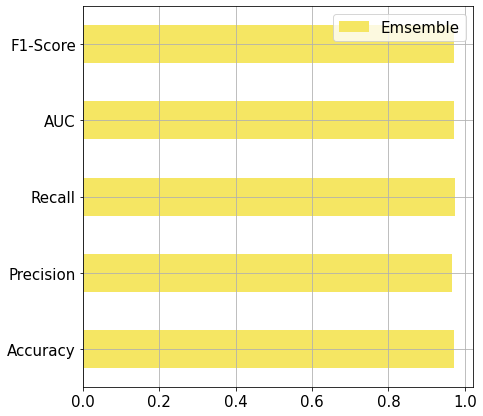

In [91]:
results_metrics = pd.DataFrame(np.array(test_metrics),
             columns =["Emsemble"],
            index = ["Accuracy","Precision","Recall","AUC","F1-Score"])
results_metrics.to_csv("results.csv")
display(results_metrics)
results_metrics.plot.barh(color=["#f5e663"],figsize=(7,7),grid=True )

In [92]:
image_path = "dataset_test/dataset_test"

def loadTestSet(path):
    def loadImages(path):
        # literalmente dar load das imagens todas para estes arrays
        # Listas por compreencao for life <3
        images = [image.load_img(image_path+"/images/"+file,target_size = (28,28), color_mode='grayscale') for file in sorted(os.listdir(image_path+"/images"))]
        return images

    def imagesToArray(imgs):
        return np.array([image.img_to_array(img)[:,:,0] for img in imgs])
    
    images = loadImages(path)
    images_array = imagesToArray(images)
    return images_array
  
test_set = loadTestSet(image_path)

In [130]:
test_set = test_set.reshape(-1, 28, 28, 1)
test_set.shape

(2000, 28, 28, 1)

In [132]:
X_test_final_features = fill_features(test_set)

In [134]:
predictions_test_final = []
for name, model in models:
    print("Testing {}".format(name))
    predictions_test_final.append(model.predict(X_test_final_features))

Testing LR
Testing LDA
Testing KNN
Testing DT
Testing RF
Testing NB
Testing SVM


In [135]:
tests_final = pd.DataFrame(np.array(predictions_test_final).T,columns = names)

In [136]:
emsemble_predict_test_final = []
for r in range(len(tests_final)):
    vote = {0:0,1:0}
    for i in range(len(w)):
        vote[tests_final.iloc[r][i]]+=w[i]

    emsemble_predict_test_final.append(max(vote, key=vote.get))
emsemble_predict_test_final = np.array(emsemble_predict_test_final)
emsemble_predict_test_final

array([0, 1, 0, ..., 1, 1, 0])

In [137]:
ids = [img.split(".")[0] for img in sorted(os.listdir("dataset_test/dataset_test/images"))]
submition = pd.DataFrame((np.array([ids,emsemble_predict_test_final]).T),columns= ["Id","Category"])
submition = submition.astype(int).sort_values("Id")
submition.to_csv("Submition_ensemble.csv",index=False)
submition

,Id,Category
0,0,0
1,1,1
1112,2,0
1223,3,1
1334,4,1
...,...,...
1107,1995,0
1108,1996,0
1109,1997,0
1110,1998,1
